In [1]:
# import the necessary libraries
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import camb
import pandas as pd
import healpy as hp
from camb import model, initialpower

#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
Nside_red=16
Nside=512
lmax=3*Nside_red-1
l_gen=4*Nside #i put l_gen >> lmax as in the other files to generate the cl

#i generate one Cl for r=r_test
const=1.88 * 10**(-9)
tau=0.06
r=0.06
pars.set_cosmology(H0=67.32, ombh2=0.02237, omch2=0.1201, mnu=0.06, omk=0, tau=tau)
pars.InitPower.set_params(As=const*np.exp(2*tau), ns=0.9651, r=r)
pars.set_for_lmax(l_gen, lens_potential_accuracy=0)
pars.WantTensors=True
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK',raw_cl=False)#spectra are multiplied by l*(l+1)/2pi, i keep them like this
#because i also need to rescale the input_cl -> so the cl i use are all scaled in the same way
totCL=powers['total']
ls = np.arange(totCL.shape[0])
cl_obs=np.asarray(totCL[0:lmax,2])# i take the C_l^BB
ell = np.arange(0,lmax+1)

[   0.            0.         1062.77997376 1001.541642    946.72632484
  906.04615453  878.15738712  860.33259682  849.5338048   844.29900884
  843.16292261  844.69955979  849.5346233   855.72380787  863.15703036
  870.78212413  880.3482778   891.67604555  903.59806006  916.86657967
  929.86895038  943.30369327  957.20131798  971.17754861  985.55308014
 1000.45880649 1015.40240183 1030.79750833 1046.47832609 1062.36093289
 1078.63593196 1094.70505928 1111.38074605 1128.12958658 1144.92329326
 1162.33653903 1179.46497127 1196.8409353  1214.57900003 1232.58298512
 1250.77273598 1269.06227659 1287.45376722 1305.95840325 1324.62452261
 1343.51532059 1362.59623528]


In [2]:
f_ = np.load('/home/amorelli/cl_generator/outfile_R_000_006.npz')# itake as input the Cl i use to generate the training set for the NN
print(f_.files) #give the keywords for the stored arrays
data_in=f_["data"]
r_in=f_["r"]
print(data_in.shape)

def unison_sorted_copies(a, b): # the function to sort two arrays in unison = i sort the first array and the 
    #the elements of the second are sorted in the same way
    assert len(a) == len(b)
    p=np.argsort(a,axis=0) #i sort a and take the array of the indexes of the sorted a elements
    a_out=np.empty_like(a) 
    b_out=np.empty_like(b)
    for i in range(len(a)): #reorder both arrays using these indexes. I need to do like this (different from unison shuffle)
        #because if not the shape of the array changes
        a_out[i]=a[p[i]]
        b_out[i]=b[p[i]]
    return a_out, b_out
r_in,data_in=unison_sorted_copies(r_in, data_in) # i sort according to r
end=len(data_in)
data=data_in[:end]
r_arr=r_in[:end]

['data', 'r']
(1100, 4, 47)
[0.00000000e+00 5.45950864e-05 1.09190173e-04 1.63785259e-04
 2.18380346e-04 2.72975432e-04 3.27570519e-04 3.82165605e-04
 4.36760692e-04 4.91355778e-04]


In [3]:
high_nside = 512
low_nside= 16
window=hp.pixwin(low_nside,lmax=lmax, pol=False)
res=hp.nside2resol(low_nside)
beam=hp.gauss_beam(2*res, lmax=lmax, pol=False)
res_low=hp.nside2resol(low_nside)
n_pix=hp.nside2npix(low_nside)
sensitivity=4/2**0.25 #i take this sensitivity because i need to compare with a NN that uses two maps
#it can be shown that is like analysing a single map with smaller sensitivity
mu, sigma = 0, sensitivity*np.deg2rad(1./60.)/res
Nl=(sensitivity*np.deg2rad(1.0/60.0))**2 #i compute the Nl (harmonic transorm of the noise)
smooth=beam*window

439.74226071262797


In [4]:
def normalize_cl(input_cl): #this is the function to divide each cl of a given spectra by l(l+1)/2pi
    output_cl=np.zeros(len(input_cl)) # i prepare the output array
    for i in range(1,len(input_cl)):
        output_cl[i]=input_cl[i]/i/(i+1)*2*np.pi # i divide each element by l(l+1)/2pi
    return output_cl
    

In [5]:
all_cl=np.zeros((len(r_arr)+1, lmax)) #i prepare an array to store all normalized spectra. The 0th element is the test spectra
all_cl[0]=normalize_cl(cl_obs)*(smooth[:lmax])**2+Nl#i normalize the test spectra and multiply the B_l*W_l and sum N_l
for i in range(1,len(r_arr)+1):
    d=data[i-1,2,:] #i take the ith C^BB(l) spectra
    all_cl[i]=normalize_cl(d)*(smooth[:lmax])**2+Nl #i normalize and .. 

(1101, 47)


In [6]:
def compute_likelihood(c_obs,c_th,l): #this takes in input the lth element of the test spectra and the lth
    #element of each input spectra
    cl_obs=c_obs[l]
    cl_th=c_th[:,l]
    logL=np.zeros(len(cl_th))
    for i,cl in enumerate(cl_th):
        cl_r=cl
        logL_i=-(2*l+1)/2*((cl_obs/cl_r)+np.log(np.abs(cl_r))-1-np.log(np.abs(cl_obs))) #this is the expression to compute 
        #the log-likelihood for a certain l<=lmax. 
        #the term -1-np.log(np.abs(cl_obs)) is addes so that for cl_r=cl_obs logL=0 -> L=1
        logL[i]=logL_i
    return(logL)
logL=0
l=lmax
for l in ell[2:l]: # i compute logL for each value of l and take the sum of all of them to get the complete likelihood
    logL+=compute_likelihood(all_cl[0],all_cl[1:],l)
L_l=np.exp(logL) 

[-2.93478454e+03 -2.52106089e+03 -2.24433921e+03 ... -3.11777912e-04
 -7.78817449e-05  2.84217094e-14]


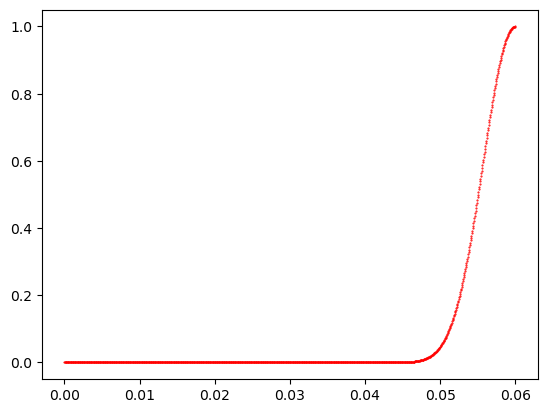

In [7]:
plt.plot(r_arr,L_l,color='r',linestyle='None',marker='.', markersize = 1.0)

In [9]:
from scipy.integrate import trapz, simps
A=trapz(L_l, r_arr) # i compute the area under the likelihood curve
L_l=L_l/A #i normalize the likelihood curve so that the area is 1
mean=trapz(L_l*r_arr, r_arr)# i compute mean from the likelihood
var=trapz(L_l*(r_arr-mean)**2,r_arr) # i compute the variance from the likelihood
sigma=var**0.5
print(mean,sigma)

0.005213230551175968
1.0000000000000002
0.05673895456165714
5.837987638268689e-06
0.0024161927982403824


0.056740783224625134 0.0024166994667840203


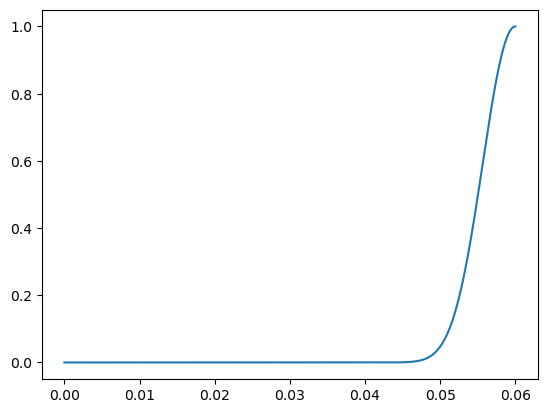

In [10]:
from scipy.interpolate import interp1d # this is another way to get sigma and mean from the likelihood function
rover = np.linspace(0,r_arr[end-1],10000) #i generate the set of points on which i want to compute the likelihood

likeover = interp1d(r_arr,logL,kind='cubic')(rover) # i interpolate the points of the likelihood curve: i generate a curve with len(rover)
#points that best fits the likelihood array so that the likelihood curve is smoother
probover = np.exp(likeover)

plt.plot(rover,probover)

meanr = np.sum(probover*rover)/np.sum(probover) # i compute directly the mean on the set of discrete points (i don't do the integral)
sigmar = np.sqrt(np.sum(probover*rover**2)/np.sum(probover) - meanr**2)
print(meanr,sigmar)